In [ ]:
# !pip install numpy scipy matplotlib tensorflow

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#i have pulled it
class SwitchedReluctanceMotor:
    """
    This class defines the Switched Reluctance Motor model.
    It calculates inductance, its derivative, and the electromagnetic torque
    based on the motor's physical parameters and current state.
    """
    def __init__(self, phase=3, Ns=12, Nr=8, R=0.9, J=0.01, B=0.005, La=0.154, Lu=0.023):
        """
        Initializes the SRM with parameters from the specification sheet.
        """
        self.phase = phase
        self.Ns = Ns  # Number of stator poles
        self.Nr = Nr  # Number of rotor poles
        self.R = R    # Stator resistance per phase [Ohm]
        self.J = J    # Moment of inertia [kg.m^2]
        self.B = B    # Friction coefficient [N.m.s]
        self.La = La  # Aligned inductance [H]
        self.Lu = Lu  # Unaligned inductance [H]
        
        # Calculate phase shift between phases in mechanical radians
        # This is the step angle for commutation
        self.phase_shift = (2 * np.pi) / (self.phase * self.Nr)

    def inductance(self, theta_m, phase_index):
        """
        Calculates the inductance of a given phase at a specific mechanical rotor angle.
        This uses a simplified triangular approximation for the inductance profile.
        
        Args:
            theta_m (float): Mechanical rotor angle [rad].
            phase_index (int): The index of the phase (0 for A, 1 for B, 2 for C).
            
        Returns:
            float: Inductance of the specified phase [H].
        """
        # Electrical angle for the given phase, considering the phase shift
        theta_e = (self.Nr * (theta_m - phase_index * self.phase_shift)) % (2 * np.pi)

        # Triangular inductance profile over one electrical period (2*pi)
        if 0 <= theta_e < np.pi:
            # Linearly increasing inductance
            return self.Lu + (self.La - self.Lu) * (theta_e / np.pi)
        else: # pi <= theta_e < 2*pi
            # Linearly decreasing inductance
            return self.La - (self.La - self.Lu) * ((theta_e - np.pi) / np.pi)

    def dL_dtheta(self, theta_m, phase_index):
        """
        Calculates the derivative of inductance with respect to the mechanical rotor angle.
        
        Args:
            theta_m (float): Mechanical rotor angle [rad].
            phase_index (int): The index of the phase (0 for A, 1 for B, 2 for C).
            
        Returns:
            float: The derivative of inductance [H/rad].
        """
        theta_e = (self.Nr * (theta_m - phase_index * self.phase_shift)) % (2 * np.pi)

        # Derivative for the triangular profile
        if 0 <= theta_e < np.pi:
            # Positive slope region (good for motoring)
            return self.Nr * (self.La - self.Lu) / np.pi
        else: # pi <= theta_e < 2*pi
            # Negative slope region (generating/braking)
            return -self.Nr * (self.La - self.Lu) / np.pi

    def torque(self, currents, theta_m):
        """
        Calculates the total electromagnetic torque produced by all phases.
        Torque = 0.5 * i^2 * dL/dtheta
        
        Args:
            currents (list): A list of currents for each phase [A].
            theta_m (float): Mechanical rotor angle [rad].
            
        Returns:
            float: Total electromagnetic torque [N.m].
        """
        total_torque = 0.0
        for i in range(self.phase):
            total_torque += 0.5 * (currents[i]**2) * self.dL_dtheta(theta_m, i)
        return total_torque


class PIController:
    """A simple Proportional-Integral (PI) controller."""
    def __init__(self, Kp, Ki, output_min, output_max):
        self.Kp = Kp
        self.Ki = Ki
        self.output_min = output_min
        self.output_max = output_max
        self.integral = 0.0
        self.prev_error = 0.0

    def update(self, error, dt):
        """Calculates the control output."""
        self.integral += error * dt
        # Anti-windup for the integral term
        self.integral = max(min(self.integral, self.output_max), self.output_min)
        
        output = self.Kp * error + self.Ki * self.integral
        
        # Clamp output to its limits
        output = max(min(output, self.output_max), self.output_min)
        return output

class HysteresisController:
    """A hysteresis-based current controller."""
    def __init__(self, band):
        self.band = band

    def update(self, i_ref, i_actual):
        """
        Determines the voltage switch state based on current error.
        Returns 1 to turn ON, 0 to turn OFF.
        """
        if i_actual < i_ref - self.band:
            return 1  # Turn ON
        elif i_actual > i_ref + self.band:
            return 0  # Turn OFF
        else:
            return None # Keep previous state


def simulate_srm_control():
    """Main function to run the closed-loop simulation."""
    print("Starting SRM simulation...")
    
    # --- Simulation Parameters ---
    T_sim = 1.0  # Total simulation time [s]
    dt = 1e-6    # Time step [s] - needs to be small for numerical stability
    N = int(T_sim / dt)

    # --- Motor and Controller Setup ---
    srm = SwitchedReluctanceMotor()
    
    # PI controller for speed loop (gains may need tuning)
    # Kp=0.5, Ki=10 provides a reasonably good response
    speed_pi = PIController(Kp=0.5, Ki=10.0, output_min=0, output_max=10.0) # Output is current reference [A]
    
    # Hysteresis current controller
    hysteresis_band = 0.1 # [A]
    current_controller = HysteresisController(hysteresis_band)
    
    # --- System Parameters ---
    V_dc = 300.0  # DC bus voltage [V]
    T_load = 5.0  # Load torque [N.m]

    # --- Commutation Logic Parameters (in mechanical degrees) ---
    theta_on_deg = 0.0
    theta_off_deg = 20.0  # Should be less than 360/Nr = 45 deg
    
    theta_on = np.deg2rad(theta_on_deg)
    theta_off = np.deg2rad(theta_off_deg)
    
    # --- State Variables Initialization ---
    theta_m = 0.0          # Mechanical angle [rad]
    omega_m = 0.0          # Mechanical speed [rad/s]
    currents = [0.0] * srm.phase
    voltages = [0.0] * srm.phase
    switch_states = [0] * srm.phase
    
    # --- Data Logging ---
    log_interval = 100 # Log data every 100 steps to save memory
    time_log = []
    speed_log = []
    torque_log = []
    currents_log = [[] for _ in range(srm.phase)]
    ref_speed_log = []

    # --- Main Simulation Loop ---
    # Set speed reference (in RPM, converted to rad/s)
    speed_ref_rpm = 1000.0
    speed_ref_rads = speed_ref_rpm * (2 * np.pi / 60)

    for i in range(N):
        # --- Speed Control Loop ---
        speed_error = speed_ref_rads - omega_m
        i_ref = speed_pi.update(speed_error, dt)

        # --- Commutation and Current Control Loop ---
        for ph in range(srm.phase):
            # Calculate the effective angle for this phase
            theta_eff = (theta_m - ph * srm.phase_shift) % ((2 * np.pi) / srm.Nr)

            # Commutation Logic: Is this phase active?
            if theta_on <= theta_eff < theta_off:
                # Active window: use hysteresis control with +Vdc and 0V (soft chopping)
                new_state = current_controller.update(i_ref, currents[ph])
                if new_state is not None:
                    switch_states[ph] = new_state
                
                voltages[ph] = V_dc if switch_states[ph] == 1 else 0.0
            else:
                # Inactive window: force demagnetization with -Vdc
                switch_states[ph] = 0 # Phase is definitely off
                if currents[ph] > 0.01: # Use a small threshold to avoid chatter
                    voltages[ph] = -V_dc
                else:
                    voltages[ph] = 0.0

        # --- Motor Dynamics (Solving ODEs using Euler method) ---
        di_dt = [0.0] * srm.phase
        inductances = [srm.inductance(theta_m, ph) for ph in range(srm.phase)]
        dL_dthetas = [srm.dL_dtheta(theta_m, ph) for ph in range(srm.phase)]
        
        # Back-EMF term
        back_emf = [dL_dthetas[ph] * omega_m * currents[ph] for ph in range(srm.phase)]

        for ph in range(srm.phase):
            # V = R*i + L*di/dt + back_emf
            di_dt[ph] = (voltages[ph] - srm.R * currents[ph] - back_emf[ph]) / inductances[ph]
            currents[ph] += di_dt[ph] * dt
            currents[ph] = max(0, currents[ph]) # Current cannot be negative

        # Mechanical dynamics
        T_e = srm.torque(currents, theta_m)
        domega_dt = (T_e - T_load - srm.B * omega_m) / srm.J
        
        omega_m += domega_dt * dt
        theta_m += omega_m * dt
        theta_m %= (2 * np.pi) # Keep angle within one revolution

        # --- Logging ---
        if i % log_interval == 0:
            time_log.append(i * dt)
            speed_log.append(omega_m * 60 / (2 * np.pi)) # store in RPM
            torque_log.append(T_e)
            ref_speed_log.append(speed_ref_rpm)
            for ph in range(srm.phase):
                currents_log[ph].append(currents[ph])

    print("Simulation finished.")
    return time_log, speed_log, ref_speed_log, torque_log, currents_log


def plot_results(time, speed, ref_speed, torque, currents):
    """Plots the simulation results."""
    fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
    
    # Speed Plot
    axs[0].plot(time, speed, label='Actual Speed')
    axs[0].plot(time, ref_speed, 'r--', label='Reference Speed')
    axs[0].set_ylabel('Speed (RPM)')
    axs[0].set_title('SRM Closed-Loop Speed Control Simulation')
    axs[0].legend()
    axs[0].grid(True)

    # Torque Plot
    axs[1].plot(time, torque)
    axs[1].set_ylabel('Electromagnetic Torque (N.m)')
    axs[1].grid(True)

    # Current Plot
    for i, i_phase in enumerate(currents):
        axs[2].plot(time, i_phase, label=f'Phase {chr(65+i)} Current')
    axs[2].set_ylabel('Phase Current (A)')
    axs[2].set_xlabel('Time (s)')
    axs[2].legend()
    axs[2].grid(True)
    
    plt.tight_layout()
    plt.show()



Starting SRM simulation...
Simulation finished.


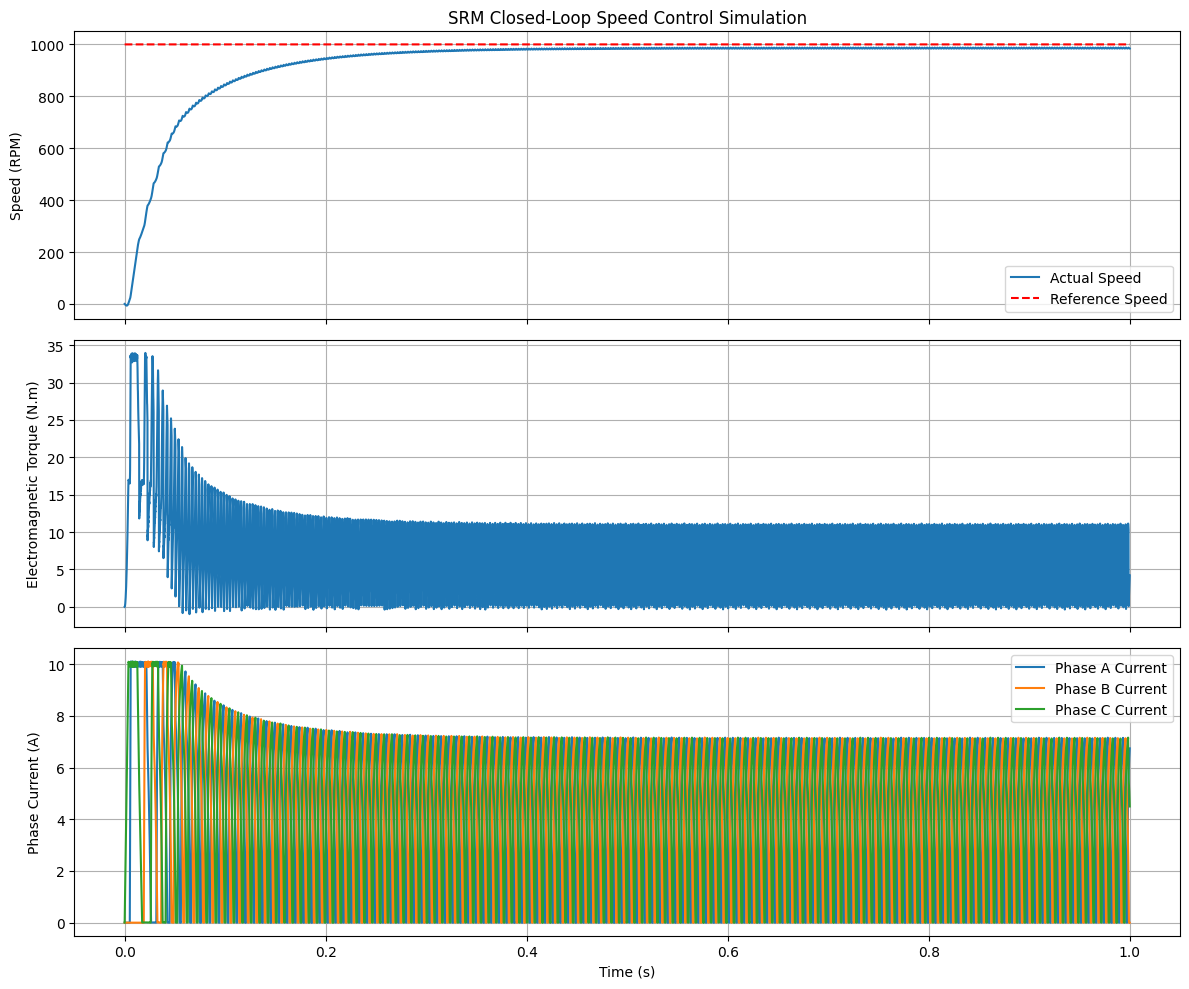

In [8]:

# Run simulation
time, speed, ref_speed, torque, currents = simulate_srm_control()

# Plot results
plot_results(time, speed, ref_speed, torque, currents)



In [14]:

# # Run simulation
# time, speed, ref_speed, torque, currents = simulate_srm_control(3,12,8,0.9,0.01,0.005,0.154,0.023)

# # Plot results
# plot_results(time, speed, ref_speed, torque, currents)
